<a href="https://colab.research.google.com/github/tugaevaea/Web_Mining/blob/master/CRF_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/MMDS/WebMining/Project"
%cd /content/drive/My Drive/MMDS/WebMining/Project

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
CRF-LSTM.ipynb	ner.csv  ner_dataset.csv
/content/drive/My Drive/MMDS/WebMining/Project


In [0]:
import pandas as pd
import numpy as np

data = pd.read_csv("ner_dataset.csv", encoding="latin1")


In [0]:
data = data.fillna(method="ffill")


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words


35179

In [6]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags


17

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [0]:
getter = SentenceGetter(data)


In [0]:
sent = getter.get_next()

In [0]:
sentences = getter.sentences



In [0]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


In [12]:
word2idx["Obama"]


12383

In [13]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]


Using TensorFlow backend.


In [0]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)


In [0]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]


In [0]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])


In [0]:
from keras.utils import to_categorical


In [0]:
y = [to_categorical(i, num_classes=n_tags) for i in y]


In [0]:
from sklearn.model_selection import train_test_split


In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)


In [21]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ovd7gsez
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ovd7gsez
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=3e51ddc985a50f3da7fe67b736ca91eea9e32c1c0294cb9dcc443f113db247cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-hey4s54x/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF


In [0]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output


In [0]:
model = Model(input, out)


In [25]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [26]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 139s 4ms/step - loss: 0.1044 - crf_viterbi_accuracy: 0.9707 - val_loss: 0.0279 - val_crf_viterbi_accuracy: 0.9845
Epoch 2/5
38846/38846 [==============================] - 138s 4ms/step - loss: -0.0170 - crf_viterbi_accuracy: 0.9904 - val_loss: -0.0248 - val_crf_viterbi_accuracy: 0.9897
Epoch 4/5
38846/38846 [==============================] - 139s 4ms/step - loss: -0.0365 - crf_viterbi_accuracy: 0.9913 - val_loss: -0.0425 - val_crf_viterbi_accuracy: 0.9900
Epoch 5/5
38846/38846 [==============================] - 139s 4ms/step - loss: -0.0544 - crf_viterbi_accuracy: 0.9919 - val_loss: -0.0593 - val_crf_viterbi_accuracy: 0.9906


In [0]:
hist = pd.DataFrame(history.history)


In [29]:
hist

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,0.027891,0.984550,0.104382,0.970701
1,-0.004421,0.988940,0.008404,0.987834
2,-0.024791,0.989699,-0.016983,0.990408
3,-0.042499,0.990028,-0.036485,0.991301
4,-0.059264,0.990590,-0.054428,0.991861


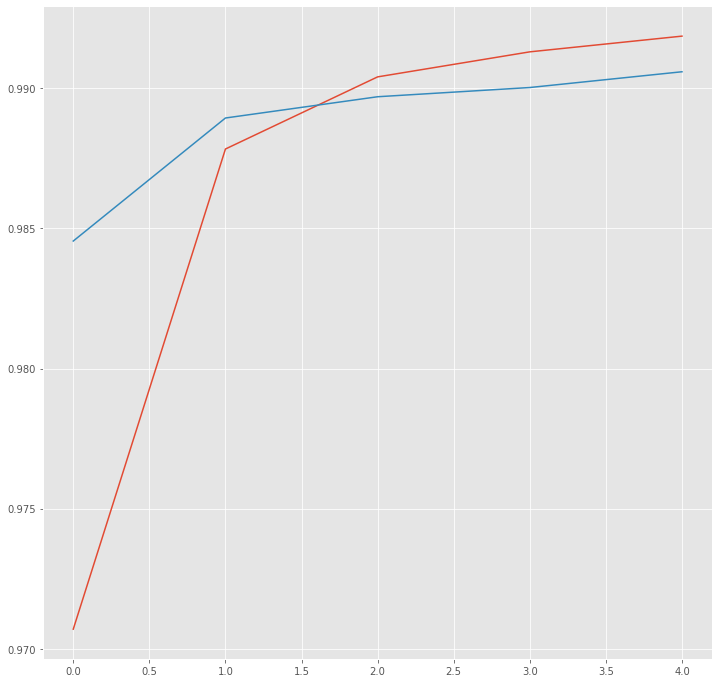

In [30]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()


In [32]:
pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=d72fb121a600d83421efe777828778b064ca26dea8ccd29c30af03d03918ddc4
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [34]:
!pip install sklearn

In [36]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 3.8MB/s 


In [0]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from  sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report

In [40]:
test_pred = model.predict(X_te, verbose=1)


4796/4796 [==============================] - 3s 720us/step


In [0]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)


In [42]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


F1-score: 82.8%


In [43]:
print(classification_report(test_labels, pred_labels))


           precision    recall  f1-score   support

      org       0.74      0.67      0.70      2032
      gpe       0.98      0.91      0.94      1607
      geo       0.84      0.90      0.87      3636
      tim       0.90      0.81      0.85      1980
      per       0.77      0.77      0.77      1760
      art       0.00      0.00      0.00        32
      eve       0.45      0.19      0.26        27
      nat       0.00      0.00      0.00        22

micro avg       0.84      0.82      0.83     11096
macro avg       0.84      0.82      0.82     11096



In [44]:
i = 1928
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))


Word           ||True ||Pred
The            : O     O
move           : O     O
could          : O     O
have           : O     O
negative       : O     O
implications   : O     O
for            : O     O
the            : O     O
EU-backed      : O     B-org
Nabucco        : O     I-org
pipeline       : O     O
project        : O     O
,              : O     O
designed       : O     O
to             : O     O
bring          : O     O
Caspian        : O     B-org
Sea            : O     I-org
gas            : O     O
to             : O     O
Europe         : B-geo B-geo
while          : O     O
bypassing      : O     O
Russia         : B-geo B-geo
.              : O     O


In [0]:
test_sentence = ["Hawking", "was", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]


In [0]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)


In [47]:
tags


['I-geo',
 'I-per',
 'I-tim',
 'B-nat',
 'B-gpe',
 'I-art',
 'B-eve',
 'B-art',
 'O',
 'B-geo',
 'I-org',
 'I-nat',
 'B-tim',
 'B-per',
 'I-gpe',
 'I-eve',
 'B-org']

In [48]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))


Word           ||Prediction
Hawking        : O    
was            : O    
a              : O    
Fellow         : O    
of             : O    
the            : O    
Royal          : B-org
Society        : I-org
,              : O    
a              : O    
lifetime       : O    
member         : O    
of             : O    
the            : O    
Pontifical     : B-org
Academy        : I-org
of             : I-org
Sciences       : I-org
,              : O    
and            : O    
a              : O    
recipient      : O    
of             : O    
the            : O    
Presidential   : O    
Medal          : O    
of             : O    
Freedom        : B-org
,              : O    
the            : O    
highest        : O    
civilian       : O    
award          : O    
in             : O    
the            : O    
United         : B-geo
States         : I-geo
.              : O    
